Acknowledgement goes to this kernel: https://www.kaggle.com/yadavsarthak/you-got-this-feature-engineering-and-lasso

I want to initially do a quick overview of the data.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy, matplotlib

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
features = train.columns.difference(['Id','SalePrice'])
all_data = pd.concat(( train.loc[:,features] , test.loc[:,features] ))
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We've talked in class about how important transforming data is to be more normal. This is one of the most succinct ways I found to perform the transformation on all the necessary data, and so I am including it here. I found it originally in the above-cited Kaggle kernel. 

In [2]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: scipy.stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [3]:
train['SalePrice'] = np.log1p(train['SalePrice'])

Looking at the columns missing values:

In [4]:
print(all_data.isnull().sum()[all_data.isnull().sum() != 0].sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64


I'll spare the details of most of these filling decisions, because there weren't a lot of big, important details. I simply looked on Kaggle at the dataset and what a missing value meant. However, LotFrontage seems fairly reasonable to fill with just the mean and Electrical, MSZoning, Utilities, Functional, SaleType, Exterior1st, and KitchenQual can be filled with the mode. Additionally, we'll be dropping MiscFeature, as MiscVal gives that information anyway. 

In [5]:
all_data.LotFrontage.fillna(value=all_data.LotFrontage.mean(), inplace=True)

all_data.Electrical.fillna(value=all_data.Electrical.mode(), inplace=True)
all_data.MSZoning.fillna(value=all_data.MSZoning.mode(), inplace=True)
all_data.Utilities.fillna(value=all_data.Utilities.mode(), inplace=True)
all_data.Functional.fillna(value=all_data.Functional.mode(), inplace=True)
all_data.SaleType.fillna(value=all_data.SaleType.mode(), inplace=True)
all_data.Exterior1st.fillna(value=all_data.Exterior1st.mode(), inplace=True)
all_data.KitchenQual.fillna(value=all_data.KitchenQual.mode(), inplace=True)

for col in all_data.columns:
    column = getattr(all_data, col)
    if np.issubdtype(column, np.number):
        column.fillna(value=0, inplace=True)
    else:
        column.fillna(value='No', inplace=True)

clean_data = all_data.drop(columns="MiscFeature");

Now we'll get dummies for all the categorical data.

In [6]:
clean_data = pd.get_dummies(clean_data)

We've already transformed the data, but before we start getting into variable selection for the model, let's get a few visuals on it.

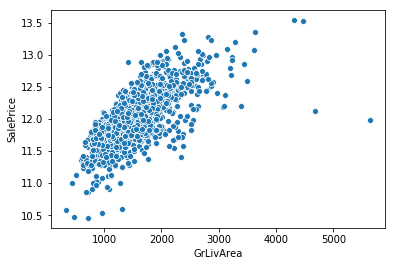

In [7]:
sns.scatterplot(train.GrLivArea, train.SalePrice)

/home/GBerg/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


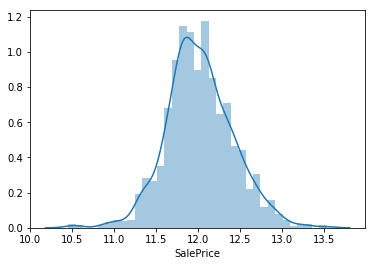

In [8]:
sns.distplot(train.SalePrice)

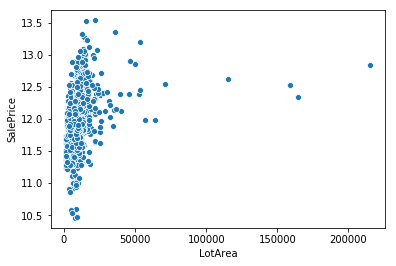

In [9]:
sns.scatterplot(train.LotArea, train.SalePrice)

There are lots of variables here, and I don't know which ones will be useful because I've never bought a house before. So, I learned about lasso regressions online and the kernel I've cited above has a good implementation of one, so I'll use that to tell me what variables will be useful in determining our end result. First, we need to make a few matrices that SciKit Learn can use.

In [10]:
X_train = clean_data[:train.shape[0]]
X_test = clean_data[train.shape[0]:]
y = train.SalePrice

#Saving these for later:
X_train_1 = X_train
X_test_1 = X_test
y_1 = y

It's important to understand how our training is going, if the model is actually doing well. So I'm including here a cross validation function that will help us with that. 

In [11]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

Now we can start using the Lasso to figure out what is going to be important. 

In [12]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression

#Just including these two lines because there's a warning that I'm actually already complying with 
#but is stubborn and won't go away.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(X_train, y)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

Mean: 0.12328552197310597
Min:  0.10356137680871387


Those scores from our cross validation look good. Here's some insight on what the lasso picked, including some nice visualization found from the kernel I've mentioned before.

Lasso picked 114 variables and eliminated the other 191 variables


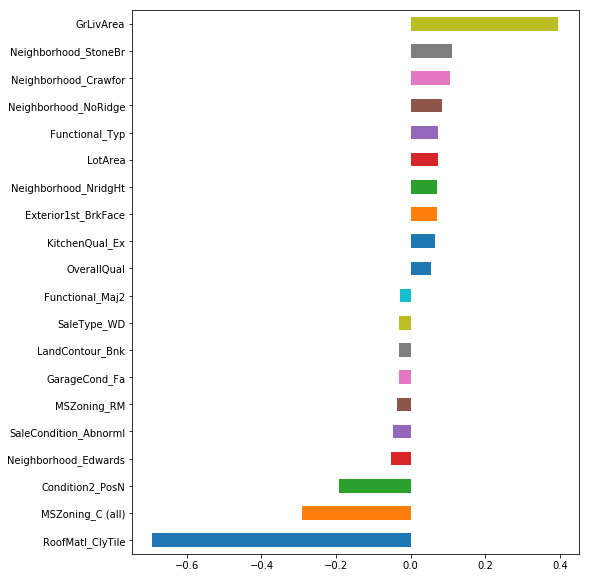

In [13]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")

Let's make some predictions with the lasso model! I feel quite confident in these results since the cross validation scores were nice and low (but not too low!) for our training data. 

In [14]:
test_preds = np.expm1(model_lasso.predict(X_test))
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission["SalePrice"] = test_preds
submission.to_csv("garrett_lasso.csv", index=False)

This got a score of 0.12119 on Kaggle, to position number 1121 on the leaderboard. Nice.

One model I've been interested in seeing is a K-nearest neighbors model. This could be useful to businesses for a few reasons: First, it's possible that there are some interaction effects that aren't perfectly captured by a linear regression model. Another is that it's very easy to visualize, which might be helpful to make the science a little more relatable and personable than a regression that might feel rather intimidating to some people. 

With the GridSearch here, we're trying out multiple values for our hyperparameter n and allowing the computer to determine the best parameters.

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(X_train_1, y_1)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train_1)
print("Train Accuracy: {}".format(mean_squared_error(y_1, y_pred_train)))

Best Params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Train Accuracy: 0.0


That training accuracy actually makes me suspect the validity and accuracy of our test results very deeply. It seems like there is probably some overfitting going on that allows for this kind of accuracy score.

In [16]:
y_pred_test = gridsearch.predict(X_test_1)
submission_1 = pd.DataFrame()
submission_1['Id'] = test['Id']
submission_1["SalePrice"] = y_pred_test
submission_1.to_csv("garrett_knearest.csv", index=False)

This one got a score of 9.453 on Kaggle, so much, much worse. But it could still be useful, I think, as a selling point to those in higher-up positions in the company. Additionally, the model could certainly be improved on while still relying on K-nearest neighbors, perhaps by managing dimensionality a little bit better or changing the weighting scheme.